In [1]:
# https://drive.google.com/file/d/17M3gBHaVnxd7GibkbxooocWWn3lJeRiP/view?usp=sharing

# !pip install -qU googledrivedownloader
# !pip install -qU https://dl.google.com/coral/python/tflite_runtime-2.1.0.post1-cp36-cp36m-linux_x86_64.whl

In [2]:
# from google_drive_downloader import GoogleDriveDownloader as gdd

# gdd.download_file_from_google_drive(file_id='17M3gBHaVnxd7GibkbxooocWWn3lJeRiP',
#                                     dest_path=f'/content/data.zip',
#                                     unzip=True)


In [3]:
import os
import shutil
import pandas as pd
# import silence_tensorflow
import matplotlib.pyplot as plt
import tensorflow as tf
from tflite_runtime.interpreter import Interpreter
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

from sklearn.model_selection import train_test_split

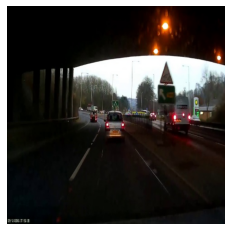

In [4]:
#@title show Not_Flood image
FOLDER = "/content/not_flood"
FILE = np.random.choice(os.listdir(FOLDER))
img= mpimg.imread(os.path.join(FOLDER, FILE))
imgplot = plt.imshow(img)
plt.axis('off')
plt.show() 

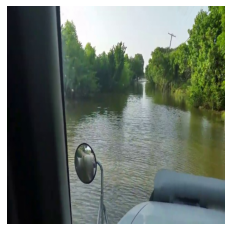

In [5]:
#@title show Flood image
FOLDER = "/content/flood"
FILE = np.random.choice(os.listdir(FOLDER))
img= mpimg.imread(os.path.join(FOLDER, FILE))
imgplot = plt.imshow(img)
plt.axis('off')
plt.show() 

In [6]:
# function to read and resize images, get labels and store them into np array

def get_image_label_resize(label, filelist, dim = (32, 32)):
    x = np.array([cv2.resize(cv2.imread(fname), dim, interpolation = cv2.INTER_AREA) for fname in filelist])
    y = np.array([label] * len(filelist))

    print('{} examples loaded for label {}'.format(x.shape[0], label))
    return (x, y)    
    

filelist_flood = glob.glob(f'/content/flood/*.jpg')
filelist_not_flood = glob.glob(f'/content/not_flood/*.jpg')

X, Y = get_image_label_resize(1, filelist_flood)
x, y = get_image_label_resize(0, filelist_not_flood)

X = np.concatenate((X ,x))
Y = np.concatenate((Y ,y))
print("X:", X.shape, "Y:", Y.shape)

perm = np.random.permutation(len(X))
X = X[perm]
Y = Y[perm]

192 examples loaded for label 1
209 examples loaded for label 0
X: (401, 32, 32, 3) Y: (401,)


In [7]:
X_train, X_validation, y_train, y_validation = train_test_split(X, Y, 
                                                                test_size=0.1, 
                                                                stratify=Y,
                                                                random_state=42)


In [8]:
n_train = X_train.shape[0]
n_validation = X_validation.shape[0]
image_shape = X_train[0].shape
n_classes = len(np.unique(y_train))
print("There are {} training examples ".format(n_train))
print("There are {} validation examples".format(n_validation))
print("Image data shape is {}".format(image_shape))
print("There are {} classes".format(n_classes))

There are 360 training examples 
There are 41 validation examples
Image data shape is (32, 32, 3)
There are 2 classes


In [9]:
# Normalize data
X_train = X_train.astype('float32')/255.0
X_validation = X_validation.astype('float32')/255.0

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 24

train_datagen = ImageDataGenerator(
    rotation_range=10,
	zoom_range=0.10,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.15,
	horizontal_flip=False,
	vertical_flip=False,
	fill_mode="nearest"
)

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)

checkpoint_filepath = '/content/flood_model'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=False,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)

In [11]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

model = models.Sequential()
model.add(layers.Conv2D(filters=16, kernel_size = (5, 5), activation='relu', input_shape = (32, 32, 3), padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(filters=32, kernel_size = (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='valid'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        1216      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 32)          9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 288)               0

In [12]:
# specify optimizer, loss function and metric
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# training batch_size=128, epochs=10
conv = model.fit(train_generator, 
                 batch_size=batch_size, 
                 epochs=30, 
                 validation_data=(X_validation, y_validation),
                 callbacks=[model_checkpoint_callback]
                )

Epoch 1/30
15/15 [==============================] - ETA: 0s - loss: 0.6814 - accuracy: 0.6472WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/resource_variable_ops.py:1817: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/flood_model/assets
15/15 [==============================] - 2s 110ms/step - loss: 0.6814 - accuracy: 0.6472 - val_loss: 0.6790 - val_accuracy: 0.7073
Epoch 2/30
15/15 [==============================] - 2s 101ms/step - loss: 0.6750 - accuracy: 0.7278 - val_loss: 0.6716 - val_accuracy: 0.7317
Epoch 3/30
15/15 [==============================] - 1s 93ms/step - loss: 0.6713 - accuracy: 0.6806 - val_loss: 0.6633 - val_accuracy: 0.7561
Epoch 4/30
15/15 [==============================] - 1s 92ms/step - loss: 

In [16]:
model = tf.keras.models.load_model('/content/flood_model')

In [20]:
model.evaluate(X_validation, y_validation)

2/2 [==============================] - 0s 5ms/step - loss: 0.3782 - accuracy: 0.9024


[0.37823936343193054, 0.9024389982223511]

In [22]:

converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = []

tflite_model = converter.convert()

tf_model_files = '/content/flood_classifier.tflie'

open(tf_model_files, "wb").write(tflite_model)

216700

In [23]:
interpreter = tf.lite.Interpreter(model_path=tf_model_files)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
input_index = input_details[0]["index"]
height = input_details[0]["shape"][1]
width = input_details[0]["shape"][2]

output_details = interpreter.get_output_details()
output_index = output_details[0]["index"]
input_index, output_index, height, width

(0, 24, 32, 32)

Label:1, Output: 1


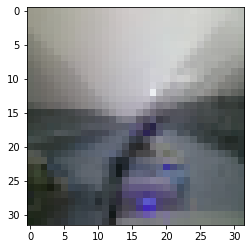

Label:1, Output: 1


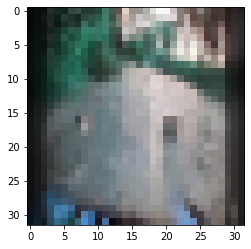

Label:1, Output: 1


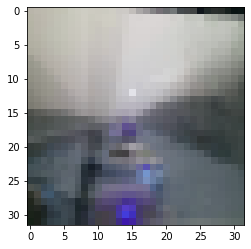

Label:1, Output: 1


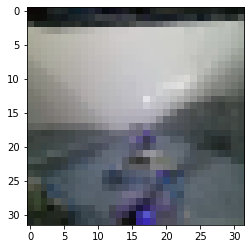

Label:0, Output: 0


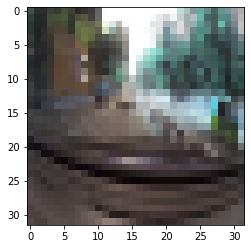

Label:0, Output: 0


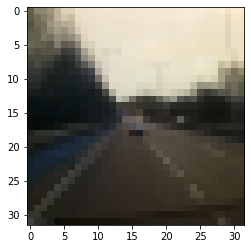

Label:0, Output: 0


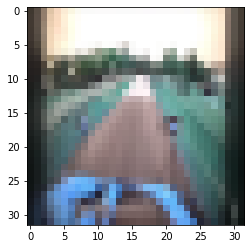

Label:1, Output: 1


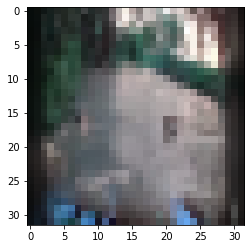

Label:0, Output: 0


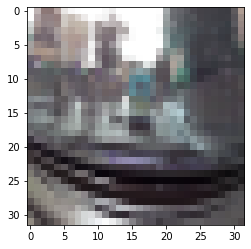

Label:0, Output: 0


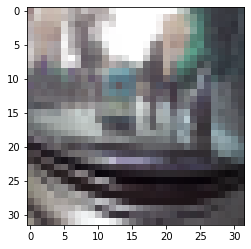

Label:0, Output: 0


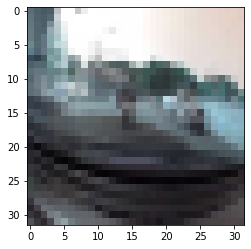

Label:0, Output: 0


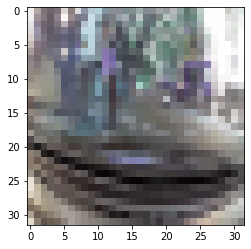

Label:0, Output: 0


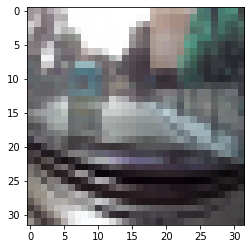

Label:0, Output: 0


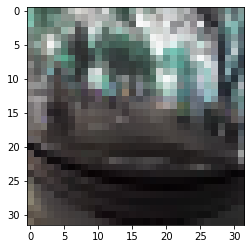

Label:1, Output: 0


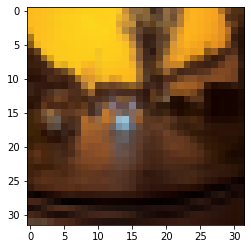

Label:0, Output: 0


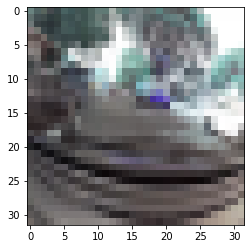

Label:0, Output: 0


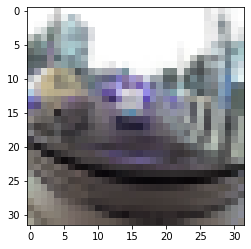

Label:0, Output: 0


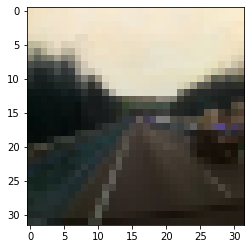

Label:0, Output: 0


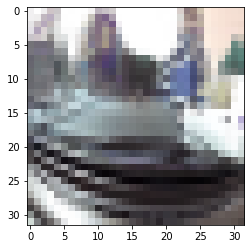

Label:1, Output: 1


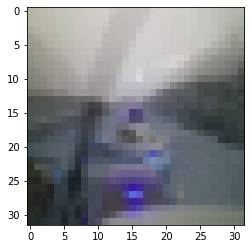

In [27]:
for i, (x, y) in enumerate(zip(X_validation, y_validation)):
    if i<20:
        plt.imshow(x.reshape(32, 32, 3))
        interpreter.set_tensor(input_index, [x])
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_index)
        print(f"Label:{y}, Output: {1 if (output_data > 0.5) else 0}")
        plt.show()